<a href="https://colab.research.google.com/github/VSennaa/ml_diabetes_classification/blob/main/perceptron_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Artigo Classificação de Diabétes com Perceptron
Colaboradores:
<p>Lucas Nunes Assumpção
<p>Pedro Henrique Araújo
<p>Victor Diniz Pessoa
<p>Vinicios Rodrigo Sena Martins

# O que é Perceptron
<p> Trata-se de um classificador linear binário, ou seja, um algoritmo capaz de discriminar duas classes através do plano cartesiano, neste caso, entre diabéticos e não diabéticos. Sua implementação consta na função treinar_perceptron.

# Conjunto de Dados (dataset)
<p>Nosso dataset foi obtido na plataforma kaggle e possui seu resumo abaixo:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

###Pre-Processamento

In [ ]:
# Carregametno do dataset
url = 'https://raw.githubusercontent.com/VSennaa/ml_diabetes_classification/refs/heads/main/Dataset_of_Diabetes.csv'
df_raw = pd.read_csv(url)
df = df_raw.copy() #Preservando o original para extração de figuras
# Limpa espaços e remove entradas inválidas
df["CLASS"] = df["CLASS"].astype(str).str.strip() #removendo os espaços pra padronizar e evitar NaN, existem alguns Y e N com espaço na string
df_cleaned = df.dropna(subset=["HbA1c", "BMI", "TG", "AGE", "CLASS"]) #Posteriormente explicado
df_cleaned = df_cleaned[df_cleaned["CLASS"].isin(["N", "Y"])].copy()

# Dados limpos
x = df_cleaned.drop("CLASS", axis=1)
y = df_cleaned["CLASS"].map({"N": 0, "Y": 1})
x["Gender"] = x["Gender"].map({"M": 0, "F": 1})

x.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,502,17975,1.0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
1,735,34221,0.0,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0
2,420,47975,1.0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
3,680,87656,1.0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
4,504,34223,0.0,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0


In [ ]:
y.head()

,CLASS
0,0
1,0
2,0
3,0
4,0


###Análise Exploratória
<p>Verificar se há dados faltantes e registrar os dados relevantes para classificação

In [ ]:
print(y.isnull().sum())  # Número total de NaNs
print(y.isna().sum())  # Número total de NaNs
print(y.value_counts(dropna=False))

0
0
CLASS
1    844
0    103
Name: count, dtype: int64


In [ ]:
print("Dados faltantes por coluna:")
x.info()

Dados faltantes por coluna:
<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         947 non-null    int64  
 1   No_Pation  947 non-null    int64  
 2   Gender     946 non-null    float64
 3   AGE        947 non-null    int64  
 4   Urea       947 non-null    float64
 5   Cr         947 non-null    int64  
 6   HbA1c      947 non-null    float64
 7   Chol       947 non-null    float64
 8   TG         947 non-null    float64
 9   HDL        947 non-null    float64
 10  LDL        947 non-null    float64
 11  VLDL       947 non-null    float64
 12  BMI        947 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 103.6 KB


É possível notar que não há dados faltantes e nem duplicatas

In [ ]:
print(x.isnull().sum())
print(x.duplicated().sum())

ID           0
No_Pation    0
Gender       1
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
dtype: int64
0


In [ ]:
print(x.describe())

               ID     No_Pation      Gender         AGE        Urea  \
count  947.000000  9.470000e+02  946.000000  947.000000  947.000000   
mean   337.390707  2.820946e+05    0.440803   54.101373    5.159074   
std    238.938561  3.473737e+06    0.496746    8.499612    2.975024   
min      1.000000  1.230000e+02    0.000000   20.000000    0.500000   
25%    125.000000  2.406350e+04    0.000000   51.000000    3.700000   
50%    295.000000  3.439000e+04    0.000000   55.000000    4.600000   
75%    546.500000  4.536950e+04    1.000000   59.000000    5.700000   
max    800.000000  7.543566e+07    1.000000   79.000000   38.900000   

               Cr       HbA1c        Chol          TG         HDL         LDL  \
count  947.000000  947.000000  947.000000  947.000000  947.000000  947.000000   
mean    69.103485    8.408617    4.878691    2.362101    1.209081    2.616304   
std     60.862961    2.544040    1.313356    1.417275    0.672423    1.127316   
min      6.000000    0.900000    0.0

##Escolha dos Dados
<p>Utilizando a correlação de Pearson para escolher os dados relevantes para a classificação

In [ ]:
# Correlação com a classe
corr = x.corrwith(y)
print(corr.sort_values(ascending=False))

corr_df = pd.DataFrame(corr.sort_values(ascending=False))

corr_df

BMI          0.539671
HbA1c        0.528732
AGE          0.405810
TG           0.181722
Chol         0.162275
VLDL         0.089292
Urea         0.056216
Cr           0.036222
LDL         -0.002771
HDL         -0.009410
ID          -0.045145
No_Pation   -0.053706
Gender      -0.127119
dtype: float64


,0
BMI,0.539671
HbA1c,0.528732
AGE,0.405810
TG,0.181722
Chol,0.162275
VLDL,0.089292
Urea,0.056216
Cr,0.036222
LDL,-0.002771
HDL,-0.009410


##Classes selecionadas:


Baseado na correleção de pearson, optou-se por HbA1c, BMI, AGE, TG, por serem classes mais fortemente relacionadas.

In [ ]:
# Selecionar features relevantes
features = ["HbA1c", "BMI", "TG", "AGE", "Chol"]
X = x[features].values.T
Y = y.values.flatten()

## --- TREINAMENTO ---
<p>Como sklearn separa por linha, precisamos fazer um "transpose" para facilitar

In [ ]:
from sklearn.model_selection import train_test_split

X_t = X.T  # (amostras X -> features)

X_temp, X_test, y_temp, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# 0.25 * 0.8 = 0.2 (20% validação)

# Transpor para uso
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T

# --- Normalizar usando só dados de treino ---
mean_train = X_train.mean(axis=1, keepdims=True)
std_train = X_train.std(axis=1, keepdims=True)

X_train_norm = (X_train - mean_train) / std_train
X_val_norm = (X_val - mean_train) / std_train
X_test_norm = (X_test - mean_train) / std_train

##Configurando Bias

In [ ]:
def add_bias(X):
    bias = np.ones((1, X.shape[1]))
    return np.vstack([bias, X])

X_train_bias = add_bias(X_train_norm)
X_val_bias = add_bias(X_val_norm)
X_test_bias = add_bias(X_test_norm)

In [ ]:
import numpy as np

def treinar_perceptron(x, y, w_inicial, eta=0.1, max_iter=1000):
    """
    Treina um perceptron simples.

    Parâmetros:
        x (ndarray): Matriz de entrada (shape: 3 x N).
        y (ndarray): Vetor de saídas esperadas (shape: N).
        w_inicial (ndarray): Pesos iniciais (shape: 3 x 1).
        eta (float): Taxa de aprendizado.
        max_iter (int): Número máximo de iterações para evitar loops infinitos.

    Retorna:
        w (ndarray): Pesos finais treinados.
        cont (int): Número de atualizações realizadas.
    """
    w = w_inicial.copy()
    # Use the values of y as a NumPy array to avoid index issues
    y_values = y.values
    e = np.ones(len(y_values))
    cont = 0
    iteracoes = 0

    while np.any(e) and iteracoes < max_iter:
        for i in range(len(y_values)):
            u = np.dot(x[:, i], w)
            f = ((np.sign(u) + 1) / 2).item()  # garante que f é escalar
            # Access y using positional index from the values array
            e[i] = y_values[i] - f
            w += eta * e[i] * x[:, i].reshape(-1, 1)
            cont += 1
        iteracoes += 1

    return w, cont


In [ ]:
def prever(x, w):
    """
    Realiza a predição dos dados de entrada usando os pesos treinados.

    Parâmetros:
        x (ndarray): Matriz de entrada (shape: 3 x N).
        w (ndarray): Vetor de pesos treinado (shape: 3 x 1).

    Retorna:
        y_pred (ndarray): Vetor de predições (0 ou 1).
    """
    u = np.dot(w.T, x)
    u = np.nan_to_num(u)  # Tratamento de NaNs
    y_pred = ((np.sign(u) + 1) / 2).astype(int).flatten()
    return y_pred

In [ ]:
w_inicial = np.zeros((X_train_bias.shape[0], 1)) # Gera os pesos iniciais
w_final, atualizacoes = treinar_perceptron(X_train_bias, y_train, w_inicial, eta=0.01, max_iter=5000)


#Analisando resultados

In [ ]:
y_val_pred = prever(X_val_bias, w_final)
print("Validação - Acurácia:", accuracy_score(y_val, y_val_pred) * 100)
print(classification_report(y_val, y_val_pred))
relatório = pd.DataFrame(classification_report(y_val, y_val_pred, output_dict=True))
relatório.to_csv('relatório.csv')

Validação - Acurácia: 96.84210526315789
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.98      0.98      0.98       169

    accuracy                           0.97       190
   macro avg       0.92      0.92      0.92       190
weighted avg       0.97      0.97      0.97       190



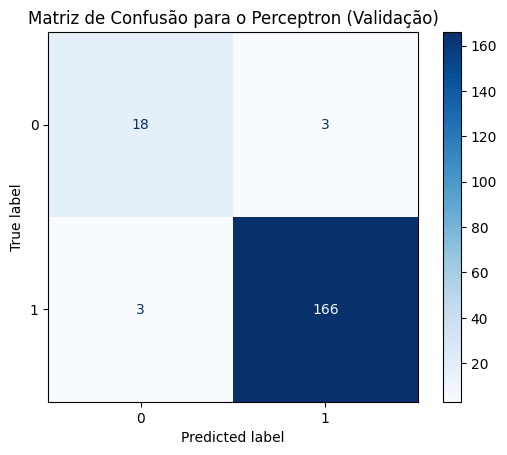

In [ ]:
# Matriz de Confusão Perceptron
cm = confusion_matrix(y_val, y_val_pred)
# Criar o gráfico da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]) # Defina os rótulos das classes conforme necessário
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão para o Perceptron (Validação)')
plt.show()

In [ ]:
y_pred = y_val_pred
print("Acurácia:", accuracy_score(y_val, y_pred))
print("Precisão:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))

Acurácia: 0.968421052631579
Precisão: 0.9822485207100592
Recall: 0.9822485207100592


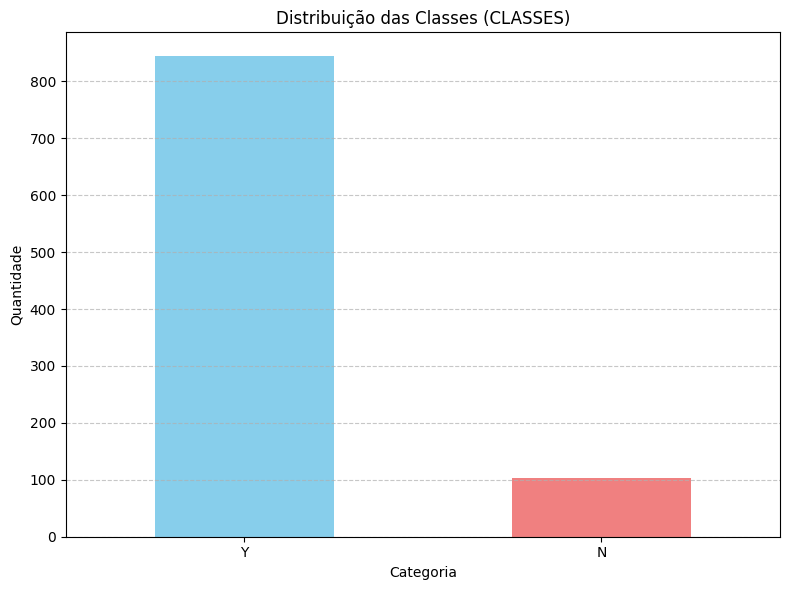

In [ ]:
# prompt: histogram of df (CLASS) using pyplot, formating in y axis as Quantidade and x as Categoria, and put Classes and save

import matplotlib.pyplot as plt
# Plotar o histograma da coluna 'CLASS'
plt.figure(figsize=(8, 6))
df_cleaned['CLASS'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribuição das Classes (CLASSES)')
plt.xlabel('Categoria')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)  # Rotacionar os rótulos do eixo x se necessário
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('CLASSES.png') # Salvar a imagem
plt.show()


In [ ]:
# prompt: save the df.head() as csv

df.head().to_csv('df_head.csv', index=False)